# Merge Tree Code Examples / Background

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from mergetree import *

## Basic Example

Below is an example of how to construct a time series and build a merge tree on top of it

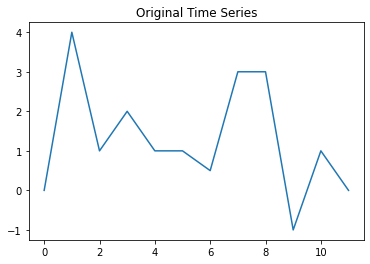

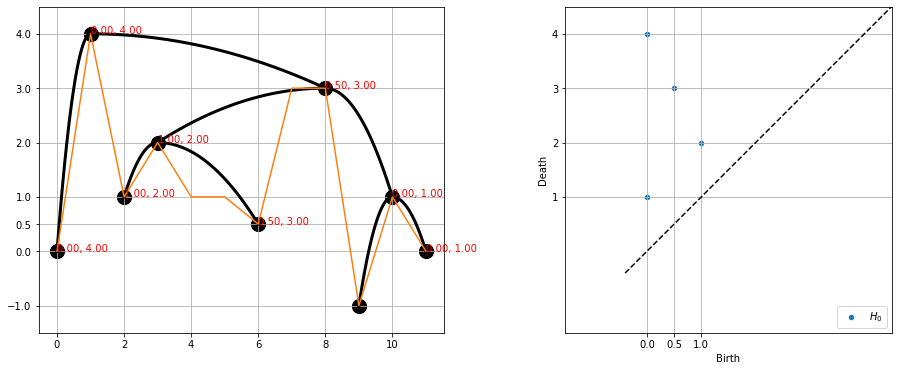

In [2]:
MT = MergeTree()
x = np.array([0, 4, 1, 2, 1, 1, 0.5, 3, 3, -1, 1, 0])
MT.init_from_timeseries(x)

plt.figure()
plt.plot(x)
plt.title("Original Time Series")

plt.figure(figsize=(16, 6))
MT.plot_with_pd(use_inorder=False, params={'use_grid':True, 'show_merge_xticks':True, 'plot_birthdeath':True})
plt.subplot(121)
plt.plot(x, c='C1')
plt.show()

One can compute the weight sequence conveniently from a method

In [3]:
print(MT.get_weight_sequence())

[4.  3.  1.5 4.  1. ]


Here's a version where circularity is assumed

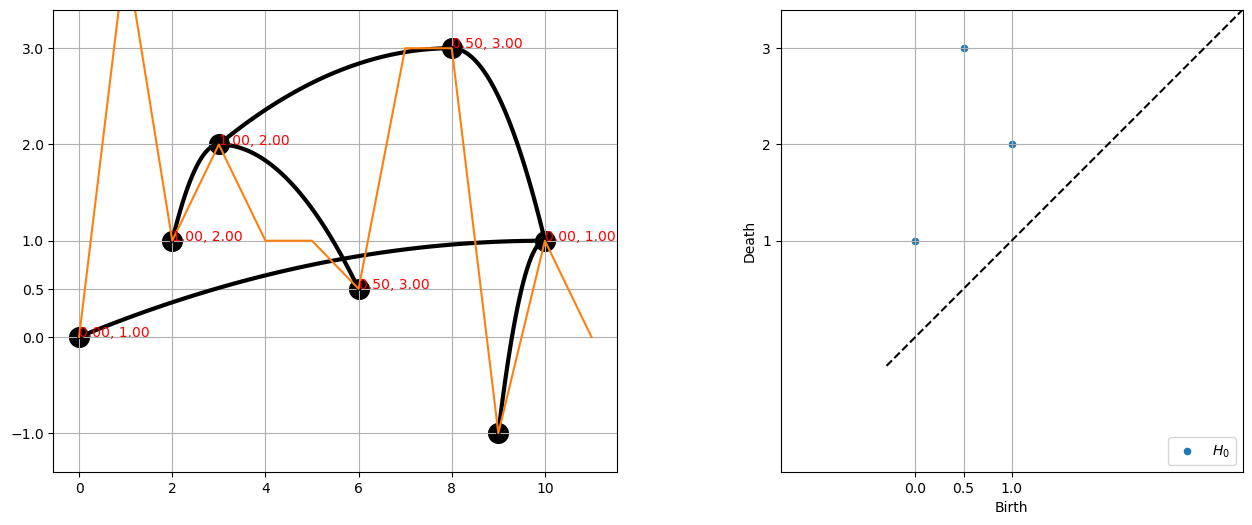

In [4]:
MT = MergeTree()
MT.init_from_timeseries(x, circular=True)
plt.figure(figsize=(16, 6))
MT.plot_with_pd(use_inorder=False, params={'use_grid':True, 'show_merge_xticks':True, 'plot_birthdeath':True})
plt.subplot(121)
plt.plot(x, c='C1')
plt.show()

## Equivalent Persistence Diagrams that aren't reflections

These examples show a lack of informativity for any features built on top of persistence diagrams

[0.  2.  3.  4.6 5. ]


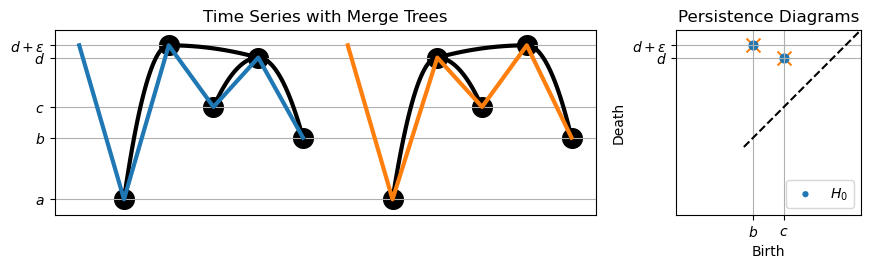

In [5]:
from persim import plot_diagrams
eps = 0.4
x1 = np.array([5, 0, 5, 3, 5-eps, 2])
x2 = np.array([5, 0, 5-eps, 3, 5, 2])

MT1 = MergeTree()
I1, _ = MT1.init_from_timeseries(x1)
MT2 = MergeTree()
I2, _ = MT2.init_from_timeseries(x2)

fac = 0.6
plt.figure(figsize=(fac*18, fac*4))
yvals = np.sort(np.unique(x1))
print(yvals)
dy = yvals[-1] - yvals[0]

plt.subplot2grid((1, 3), (0, 0), colspan=2)
MT1.plot(False)
plt.plot(x1, linewidth=3)
offset=6
MT2.plot(False, params={'offset':np.array([offset, 0])})
plt.plot(np.arange(len(x2))+offset, x2, linewidth=3)
ticks = ["$a$", "$b$", "$c$", "$d$", "$d+\epsilon$"]
plt.yticks(yvals, ticks)
plt.ylim(yvals[0]-0.1*dy, yvals[-1]+0.1*dy)
plt.gca().set_xticks([])
plt.grid()
#plt.title("$\\epsilon = {}$".format(eps))
plt.title("Time Series with Merge Trees")

plt.subplot(133)
plot_diagrams(I1)
#plt.scatter(I2[:, 0], I2[:, 1], 20)
plt.scatter(I2[:, 0], I2[:, 1], 100, marker='x')
plt.scatter(I2[:, 0], I2[:, 1], 40, c='C0')
#plt.legend(["", "First", "Second"])
plt.xticks(yvals, ticks)
plt.yticks(yvals, ticks)
plt.ylim(yvals[0]-0.1*dy, yvals[-1]+0.1*dy)
plt.gca().set_xticks(np.unique(I1[:, 0]))
plt.gca().set_yticks(np.unique(I1[:, 1]))
plt.xlim(yvals[0]-0.1*dy, yvals[-1]+0.1*dy)
plt.grid()
plt.title("Persistence Diagrams")
plt.savefig("BlindRotation.svg", bbox_inches='tight')

## Time Series -> Merge Tree -> Piecewise Linear Representative

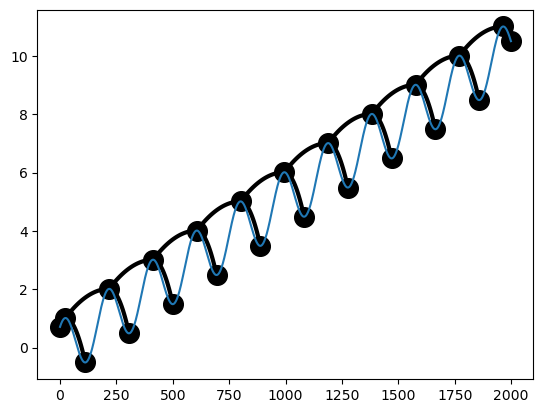

In [6]:
N = 2000
t = np.linspace(-0.1, 10.2, N)
y = np.cos(2*np.pi*t) + t

MT = MergeTree()
MT.init_from_timeseries(y)
MT.plot(use_inorder=False)
plt.plot(y)

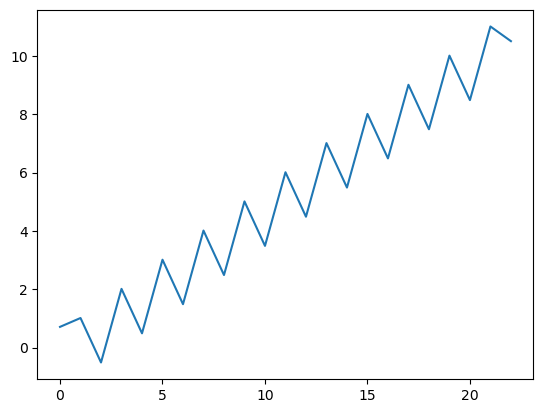

In [7]:
plt.plot(MT.crit)

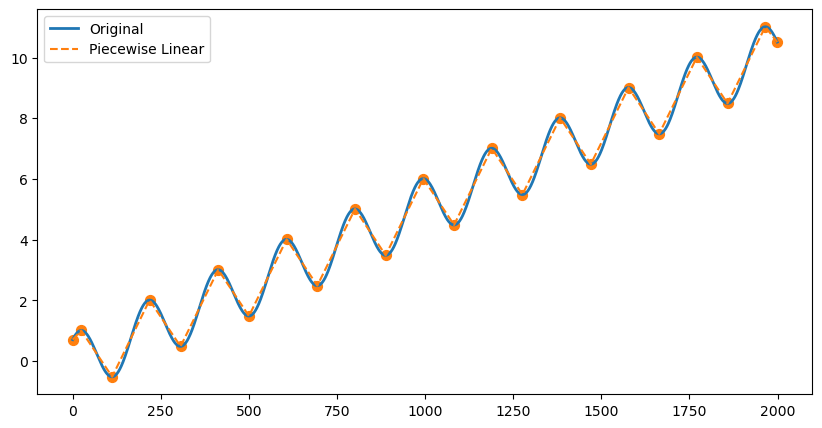

In [8]:
res = MT.get_rep_timeseries()
xlinear, ylinear = res['xs'], res['ys']
plt.figure(figsize=(10, 5))
plt.plot(y, linewidth=2)
plt.plot(xlinear, ylinear, linestyle='--')
plt.scatter(xlinear, ylinear, 50, c='C1')
plt.legend(["Original", "Piecewise Linear"])

## Collapsing Insignificant Saddles

This is one of the approaches that the merge tree edit distance paper takes to mitigate its lack of stability in practice, though there are no theoretical guarantees of stability in general in this paper

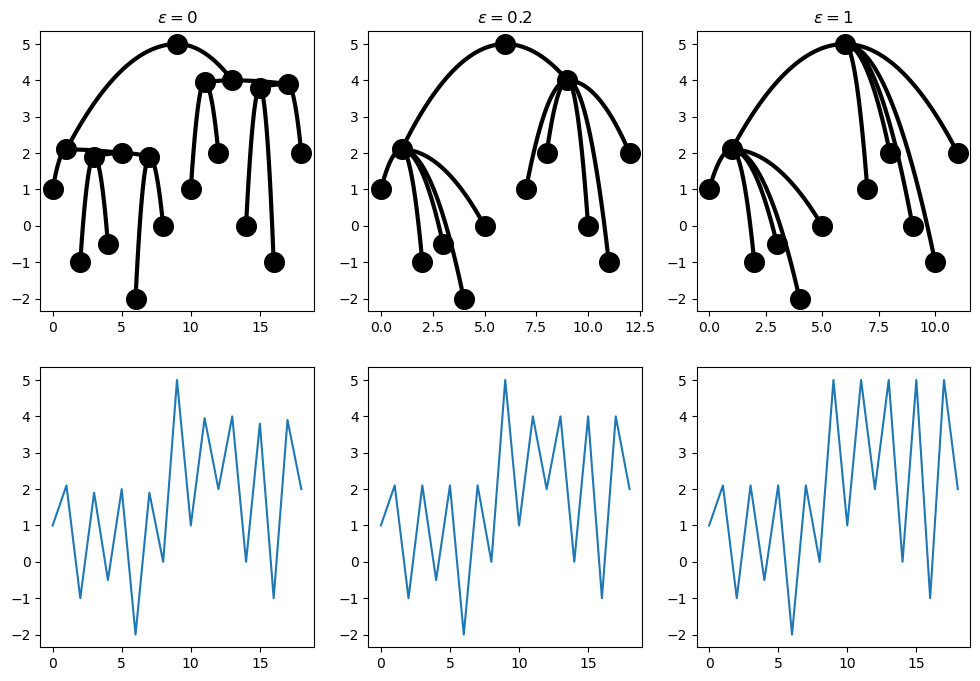

In [9]:
x = np.array([1, 2.1, -1, 1.9, -0.5, 2, -2, 1.9, 0, 5, 1, 3.95, 2, 4, 0, 2.5, 3.8, -1, 3.9, 2])
eps1 = 0
MT1 = MergeTree()
MT1.init_from_timeseries(x)

eps2 = 0.2
MT2 = MergeTree()
MT2.init_from_timeseries(x)
MT2.collapse_saddles(eps2)

eps3 = 1
MT3 = MergeTree()
MT3.init_from_timeseries(x)
MT3.collapse_saddles(eps3)

plt.figure(figsize=(12, 8))
for i, (eps, MT) in enumerate(zip([eps1, eps2, eps3], [MT1, MT2, MT3])):
    plt.subplot(2, 3, i+1)
    MT.plot(True)
    plt.title("$\\epsilon = {}$".format(eps))
    plt.subplot(2, 3, 3+i+1)
    res = MT.get_rep_timeseries()
    plt.plot(res['ys'])

## Persistence Simplification

To cut down on noise, do a simplification where all leaf nodes under a certain persistence level are removed

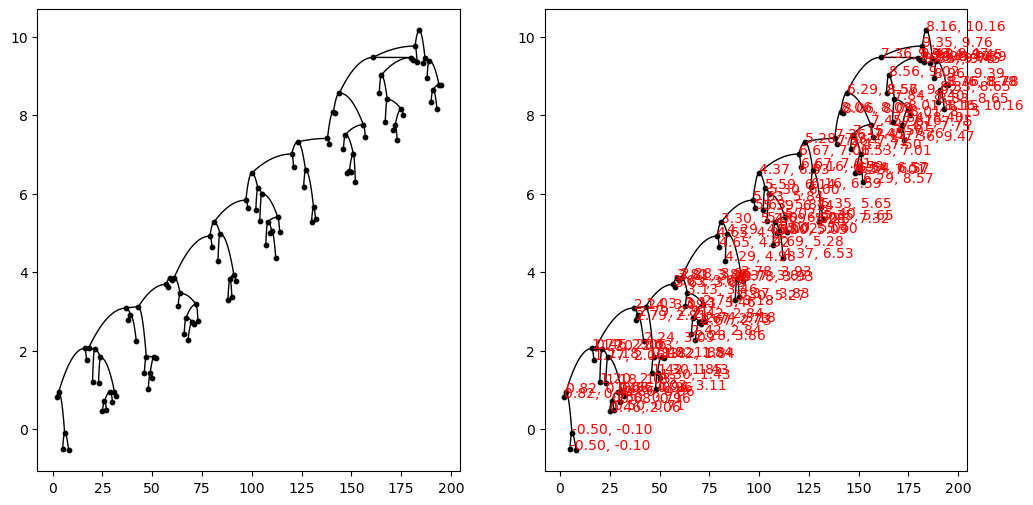

In [10]:
circular=False

np.random.seed(0)
N = 200
t = np.linspace(0.01, 0.98, N)
x = np.cos(2*np.pi*t*10) + t*10
x += 0.3*np.random.randn(N)

plt.figure(figsize=(12, 6))
plt.subplot(121)
MT = MergeTree()
MT.init_from_timeseries(x)
MT.plot(False, {'pointsize':10, 'linewidth':1})

plt.subplot(122)
MT.persistence_simplify(1)
MT.plot(False, {'pointsize':10, 'linewidth':1, 'plot_birthdeath':True})

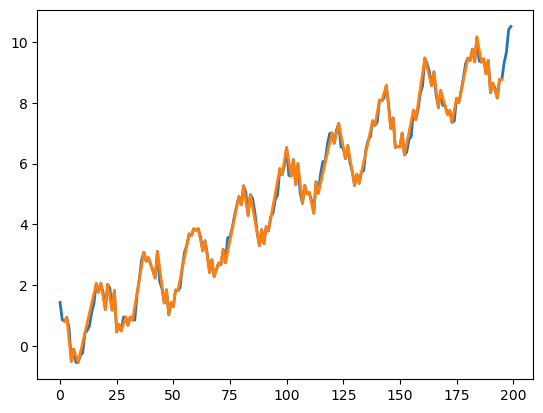

In [11]:
res = MT.get_rep_timeseries()
plt.plot(x, linewidth=2)
plt.plot(res['xs'], res['ys'], linewidth=2)